# Testing
### Wohnungsbau nach Zimmerzahl, Bauprojektstatus und Stadtquartier seit 2009
Datum: 03.02.2022

**Dataset auf INTEG Datenkatalog**:  https://data.integ.stadt-zuerich.ch/dataset/int_dwh_bau_neubau_whg-projektiert_projstatus_zizahl_quartier_seit2009_od5022

**Dataset auf PROD Datenkatalog**:  https://data.stadt-zuerich.ch/dataset/bau_neubau_whg-projektiert_projstatus_zizahl_quartier_seit2009_od5022


### Importiere die notwendigen Packages

In [1]:
#%pip install geopandas altair fiona requests folium mplleaflet contextily seaborn datetime plotly leafmap

In [2]:
import pandas as pd
import pivottablejs
from pivottablejs import pivot_ui
import numpy as np
import altair as alt
import matplotlib.pyplot as plt

import datetime
import geopandas as gpd
import folium 
import plotly.express as px
import seaborn as sns
import leafmap

import requests
import io

import plotly.express as px


In [3]:
SSL_VERIFY = False
# evtl. SSL_VERIFY auf False setzen wenn die Verbindung zu https://www.gemeinderat-zuerich.ch nicht klappt (z.B. wegen Proxy)
# Um die SSL Verifikation auszustellen, bitte die nächste Zeile einkommentieren ("#" entfernen)
# SSL_VERIFY = False

In [4]:
if not SSL_VERIFY:
    import urllib3
    urllib3.disable_warnings()

Definiere Settings. Hier das Zahlenformat von Float-Werten (z.B. *'{:,.2f}'.format* mit Komma als Tausenderzeichen), 

In [5]:
#pd.options.display.float_format = lambda x : '{:,.1f}'.format(x) if (np.isnan(x) | np.isinf(x)) else '{:,.0f}'.format(x) if int(x) == x else '{:,.1f}'.format(x)
pd.options.display.float_format = '{:.0f}'.format
pd.set_option('display.width', 100)
pd.set_option('display.max_columns', 15)

### Zeitvariabeln
Bestimme den aktuellst geladenen Monat. Hier ist es der Stand vor 2 Monaten. 
Bestimme noch weitere evt. sinnvolle Zeitvariabeln.

Zum Unterschied zwischen import datetime und from datedtime import datetime, siehe https://stackoverflow.com/questions/15707532/import-datetime-v-s-from-datetime-import-datetime

Zuerst die Zeitvariabeln als Strings

In [6]:
#today_date = datetime.date.today()
#date_time = datetime.datetime.strptime(date_time_string, '%Y-%m-%d %H:%M')
now = datetime.date.today()
date_today = now.strftime("%Y-%m-%d")
year_today = now.strftime("%Y")
month_today = now.strftime("%m")
day_today = now.strftime("%d")


Und hier noch die Zeitvariabeln als Integers:
- `aktuellesJahr`
- `aktuellerMonat`: Der gerade jetzt aktuelle Monat
- `selectedMonat`: Der aktuellste Monat in den Daten. In der Regel zwei Monate her.

In [7]:
#now = datetime.now() 
int_times = now.timetuple()

aktuellesJahr = int_times[0]
aktuellerMonat = int_times[1]
selectedMonat = int_times[1]-2

print(aktuellesJahr, 
      aktuellerMonat,
    'datenstand: ', selectedMonat,
     int_times)


2022 8 datenstand:  6 time.struct_time(tm_year=2022, tm_mon=8, tm_mday=25, tm_hour=0, tm_min=0, tm_sec=0, tm_wday=3, tm_yday=237, tm_isdst=-1)


Berechne die Variable Epoche um später das SAS-Datum in ein Unix-Datum umzuwandeln. Bei SAS beginnt die Epoche am 1.1.1960. Bei Unix am 1.1.1970.
Diese Variable wird beim CSV-Import benötigt.

In [8]:
epoch = datetime.datetime(1960, 1, 1)

### Setze einige Pfadvariabeln

- Der Packagename ist eigentlich der **Verzeichnisname** unter dem die Daten und Metadaten auf der Dropzone abgelegt werden.
- Definiert wird er bei SASA-Prozessen auf dem **Produkte-Sharepoint ([Link](https://kollaboration.intranet.stzh.ch/orga/ssz-produkte/Lists/SASA_Outputs/PersonalViews.aspx?PageView=Personal&ShowWebPart={6087A3E7-8AC8-40BA-8278-DECFACE124FF}))**.
- Der Packagename wird auf CKAN teil der URL, daher ist die exakte Schreibweise wichtig.

Beachte: im Packagename müssen alle Buchstaben **klein** geschrieben werden. Dies weil CKAN aus grossen kleine Buchstaben macht.

**BITTE HIER ANPASSEN**

In [9]:
package_name = "bau_neubau_whg-projektiert_projstatus_zizahl_quartier_seit2009_od5022"

In [10]:
dataset_name = "BAU502OD5022.csv"

**Statische Pfade in DWH-Dropzones**

In [11]:
dropzone_path_integ = r"\\szh\ssz\applikationen\OGD_Dropzone\INT_DWH"

In [12]:
dropzone_path_prod = r"\\szh\ssz\applikationen\OGD_Dropzone\DWH"

**Statische Pfade CKAN-URLs**

In [13]:
ckan_integ_url ="https://data.integ.stadt-zuerich.ch/dataset/int_dwh_"

In [14]:
ckan_prod_url ="https://data.stadt-zuerich.ch/dataset/"

### Checke die Metadaten auf der CKAN INTEG- oder PROD-Webseite

Offenbar lassen sich aktuell im Markdownteil keine Variabeln ausführen, daher gehen wir wie unten gezeigt vor. Siehe dazu: https://data-dive.com/jupyterlab-markdown-cells-include-variables
Instead of setting the cell to Markdown, create Markdown from withnin a code cell! We can just use python variable replacement syntax to make the text dynamic

In [15]:
from IPython.display import Markdown as md

In [16]:
md(" **1. Dataset auf INTEG-Datakatalog:** Link {} ".format(ckan_integ_url+package_name))

 **1. Dataset auf INTEG-Datakatalog:** Link https://data.integ.stadt-zuerich.ch/dataset/int_dwh_bau_neubau_whg-projektiert_projstatus_zizahl_quartier_seit2009_od5022 

In [17]:
md(" **2. Dataset auf PROD-Datakatalog:** Link {} ".format(ckan_prod_url+package_name))

 **2. Dataset auf PROD-Datakatalog:** Link https://data.stadt-zuerich.ch/dataset/bau_neubau_whg-projektiert_projstatus_zizahl_quartier_seit2009_od5022 

### Importiere einen Datensatz 

Definiere zuerst folgende Werte:
1) Kommt der Datensatz von PROD oder INTEG?
2) Beziehst Du den Datensatz direkt ab der DROPZONE oder aus dem INTERNET?

In [18]:
#Die Datasets sind nur zum Testen auf INT-DWH-Dropzone. Wenn der Test vorbei ist, sind sie auf PROD. 
# Über den Status kann man einfach switchen

status = "prod"; #prod vs something else
data_source = "web"; #dropzone vs something else
print(status+" - "+ data_source)

prod - web


In [19]:
# Filepath
if status == "prod":
    if data_source == "dropzone":
            fp = dropzone_path_prod+"\\"+ package_name +"\\"+dataset_name
            print("fp lautet:"+fp)
    else:
        #fp = r"https://data.stadt-zuerich.ch/dataset/bau_neubau_whg_bausm_rinh_geb_projstatus_quartier_seit2009_od5011/download/BAU501OD5011.csv"
        fp = ckan_prod_url+package_name+'/download/'+dataset_name
        print("fp lautet:"+fp)
else:
    if data_source == "dropzone":
        fp = dropzone_path_integ+"\\"+ package_name +"\\"+dataset_name
        print("fp lautet:"+fp)
    else:
        #fp = r"https://data.stadt-zuerich.ch/dataset/bau_neubau_whg_bausm_rinh_geb_projstatus_quartier_seit2009_od5011/download/BAU501OD5011.csv"
        fp = ckan_integ_url+package_name+'/download/'+dataset_name
        print("fp lautet:"+fp)


fp lautet:https://data.stadt-zuerich.ch/dataset/bau_neubau_whg-projektiert_projstatus_zizahl_quartier_seit2009_od5022/download/BAU502OD5022.csv


Beachte, wie das SAS Datum (ohne Format) in ein UNIX Datum umgerechnet und als Datumsformat dargestellt wird! Siehe dazu `https://stackoverflow.com/questions/26923564/convert-sas-numeric-to-python-datetime`

In [20]:
# Read the data
if data_source == "dropzone":
    data2betested = pd.read_csv(
        fp
        , sep=','
        ,parse_dates=['Jahr']
        ,low_memory=False
    )
    print("dropzone")
else:
    r = requests.get(fp, verify=False)  
    r.encoding = 'utf-8'
    data2betested = pd.read_csv(
        io.StringIO(r.text)
        ,parse_dates=['Jahr']
        # KONVERTIERE DAS SAS DATUM IN EIN UNIXDATUM UND FORMATIERE ES
        #, date_parser=lambda s: epoch + datetime.timedelta(days=int(s))
        ,low_memory=False)
    print("web")

data2betested.dtypes

web


Jahr              datetime64[ns]
QuarSort                   int64
QuarCd                     int64
QuarLang                  object
KreisSort                  int64
KreisCd                    int64
KreisLang                 object
ProjStatus                object
ProjStatusSort             int64
Whg1Zi                     int64
Whg2Zi                     int64
Whg3Zi                     int64
Whg4Zi                     int64
Whg5Ziplus                 int64
dtype: object

Berechne weitere Attribute falls notwendig

In [21]:
data2betested = (
    data2betested
    .copy()
    .assign(
        #Aktualisierungs_Datum_str= lambda x: x.Aktualisierungs_Datum.astype(str),
        Jahr_str = lambda x: x.Jahr.astype(str),
    )
    .sort_values('Jahr', ascending=False)
    )
data2betested.dtypes

Jahr              datetime64[ns]
QuarSort                   int64
QuarCd                     int64
QuarLang                  object
KreisSort                  int64
KreisCd                    int64
KreisLang                 object
ProjStatus                object
ProjStatusSort             int64
Whg1Zi                     int64
Whg2Zi                     int64
Whg3Zi                     int64
Whg4Zi                     int64
Whg5Ziplus                 int64
Jahr_str                  object
dtype: object

 - 1) Zeige eine kurze Vorschau der importierten Daten
 - 2) Weise die Datentypen aus
 - 3) Zeige die Shape (Umfang) des Datensatzes an

In [22]:
#data2betested.head(6)

In [23]:
data2betested.dtypes

Jahr              datetime64[ns]
QuarSort                   int64
QuarCd                     int64
QuarLang                  object
KreisSort                  int64
KreisCd                    int64
KreisLang                 object
ProjStatus                object
ProjStatusSort             int64
Whg1Zi                     int64
Whg2Zi                     int64
Whg3Zi                     int64
Whg4Zi                     int64
Whg5Ziplus                 int64
Jahr_str                  object
dtype: object

In [24]:
data2betested.shape

(884, 15)

Beschreibe einzelne Attribute

In [25]:
data2betested.describe()

,QuarSort,QuarCd,KreisSort,KreisCd,ProjStatusSort,Whg1Zi,Whg2Zi,Whg3Zi,Whg4Zi,Whg5Ziplus
count,884,884,884,884,884,884,884,884,884,884
mean,65,65,6,6,6702,10,37,46,33,10
std,36,36,4,4,1,26,62,74,56,18
min,11,11,1,1,6702,0,0,0,0,0
25%,33,33,3,3,6702,0,0,2,0,0
50%,67,67,6,6,6702,1,11,16,11,3
75%,92,92,9,9,6703,7,47,57,39,11
max,123,123,12,12,6703,280,637,564,456,160


Wie viele Nullwerte gibt es im Datensatz?

In [26]:
data2betested.isnull().sum()

Jahr              0
QuarSort          0
QuarCd            0
QuarLang          0
KreisSort         0
KreisCd           0
KreisLang         0
ProjStatus        0
ProjStatusSort    0
Whg1Zi            0
Whg2Zi            0
Whg3Zi            0
Whg4Zi            0
Whg5Ziplus        0
Jahr_str          0
dtype: int64

### Verwende das Datum als Index

While we did already parse the `datetime` column into the respective datetime type, it currently is just a regular column. 
**To enable quick and convenient queries and aggregations, we need to turn it into the index of the DataFrame**

In [27]:
data2betested = data2betested.set_index("Jahr")

In [28]:
data2betested.info()
data2betested.index.day.unique()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 884 entries, 2021-01-01 to 2009-01-01
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   QuarSort        884 non-null    int64 
 1   QuarCd          884 non-null    int64 
 2   QuarLang        884 non-null    object
 3   KreisSort       884 non-null    int64 
 4   KreisCd         884 non-null    int64 
 5   KreisLang       884 non-null    object
 6   ProjStatus      884 non-null    object
 7   ProjStatusSort  884 non-null    int64 
 8   Whg1Zi          884 non-null    int64 
 9   Whg2Zi          884 non-null    int64 
 10  Whg3Zi          884 non-null    int64 
 11  Whg4Zi          884 non-null    int64 
 12  Whg5Ziplus      884 non-null    int64 
 13  Jahr_str        884 non-null    object
dtypes: int64(10), object(4)
memory usage: 103.6+ KB


Int64Index([1], dtype='int64', name='Jahr')

### Einfache Visualisierungen zur Plausi

Exploriere die Daten mit Pivottable.JS

In [29]:
from pivottablejs import pivot_ui

pivot_ui(data2betested)

### Zeitpunkte und Zeiträume abfragen

A particular powerful feature of the Pandas DataFrame is its indexing capability that also works using time-based entities, such as dates and times. We have already created the index above, so let's put it to use.

In [30]:
data2betested.loc["2009":"2021"].query('ProjStatus != "Im Bau"')
#data2betested.loc["2021-10-31":"2021-11-30"].head(2)

,QuarSort,QuarCd,QuarLang,KreisSort,KreisCd,KreisLang,ProjStatus,ProjStatusSort,Whg1Zi,Whg2Zi,Whg3Zi,Whg4Zi,Whg5Ziplus,Jahr_str
Jahr,,,,,,,,,,,,,,
2021-01-01,123,123,Hirzenbach,12,12,Kreis 12,Bewilligt,6702,0,9,10,10,0,2021-01-01
2021-01-01,44,44,Hard,4,4,Kreis 4,Baubegonnen,6703,2,106,126,57,34,2021-01-01
2021-01-01,34,34,Sihlfeld,3,3,Kreis 3,Baubegonnen,6703,49,32,9,16,1,2021-01-01
2021-01-01,34,34,Sihlfeld,3,3,Kreis 3,Bewilligt,6702,7,37,16,0,1,2021-01-01
2021-01-01,41,41,Werd,4,4,Kreis 4,Baubegonnen,6703,0,7,5,0,0,2021-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009-01-01,74,74,Witikon,7,7,Kreis 7,Baubegonnen,6703,0,0,2,3,2,2009-01-01
2009-01-01,73,73,Hirslanden,7,7,Kreis 7,Bewilligt,6702,1,0,9,7,0,2009-01-01
2009-01-01,73,73,Hirslanden,7,7,Kreis 7,Baubegonnen,6703,0,6,12,13,8,2009-01-01


### Visualisierungen nach Zeitausschnitten

#### Entwicklung Wohnungen nach Projektstatus und Zimmerzahl

In [31]:
data2betested.columns

Index(['QuarSort', 'QuarCd', 'QuarLang', 'KreisSort', 'KreisCd', 'KreisLang', 'ProjStatus',
       'ProjStatusSort', 'Whg1Zi', 'Whg2Zi', 'Whg3Zi', 'Whg4Zi', 'Whg5Ziplus', 'Jahr_str'],
      dtype='object')

In [32]:
#myAgg = data2betested.loc["2008-11-30":"2021-10-31"]
myAgg = data2betested.loc["2009":"2021"]\
    .groupby(['Jahr','ProjStatus', 'ProjStatusSort']) \
    .agg(sum_Whg1Zi=('Whg1Zi', 'sum'),sum_Whg2Zi=('Whg2Zi', 'sum'),sum_Whg3Zi=('Whg3Zi', 'sum'),sum_Whg4Zi=('Whg4Zi', 'sum'),sum_Whg5Ziplus=('Whg5Ziplus', 'sum'),) \
    .sort_values('Jahr', ascending=True) 
myAgg.reset_index()

,Jahr,ProjStatus,ProjStatusSort,sum_Whg1Zi,sum_Whg2Zi,sum_Whg3Zi,sum_Whg4Zi,sum_Whg5Ziplus
0,2009-01-01,Baubegonnen,6703,80,737,1457,1473,429
1,2009-01-01,Bewilligt,6702,122,778,890,823,290
2,2010-01-01,Baubegonnen,6703,152,1105,1622,1632,440
3,2010-01-01,Bewilligt,6702,126,882,951,677,222
4,2011-01-01,Baubegonnen,6703,348,1225,1452,1235,319
5,2011-01-01,Bewilligt,6702,213,1120,1230,958,395
6,2012-01-01,Baubegonnen,6703,335,1340,1471,844,282
7,2012-01-01,Bewilligt,6702,148,1170,1653,1438,460
8,2013-01-01,Baubegonnen,6703,202,1436,1752,1446,541
9,2013-01-01,Bewilligt,6702,104,1181,1837,1435,424


In [33]:
highlight = alt.selection(type='single', on='mouseover',
                          fields=['ProjStatus'], nearest=True)
#x='date:StichtagDatJahr',
base = alt.Chart(myAgg.reset_index(), title="Title").encode(
    x=alt.X('Jahr', axis=alt.Axis(title='Jahr'))# , axis=alt.Axis(format='%', title='percentage')
    , y=alt.X('sum_Whg2Zi', axis=alt.Axis(title='Anz. abgebrochener Wohnungen'))
    , color=alt.Color('ProjStatus', legend=alt.Legend(title="ProjStatus", orient="right"))  
    ,tooltip=['Jahr', 'ProjStatus','sum_Whg1Zi', 'sum_Whg2Zi', 'sum_Whg3Zi']    
)
points = base.mark_circle().encode(
    opacity=alt.value(0.75)
).add_selection(
    highlight
).properties(
    width=750 , height=350
)
lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(0.5), alt.value(4))
).interactive()

lines + points

alt.LayerChart(...)

#### Entwicklung neuerstellter Wohnungen nach Eigentumsart

In [34]:
data2betested.dtypes


QuarSort           int64
QuarCd             int64
QuarLang          object
KreisSort          int64
KreisCd            int64
KreisLang         object
ProjStatus        object
ProjStatusSort     int64
Whg1Zi             int64
Whg2Zi             int64
Whg3Zi             int64
Whg4Zi             int64
Whg5Ziplus         int64
Jahr_str          object
dtype: object

In [35]:
#myAgg = data2betested.loc["2008-11-30":"2021-10-31"]
myAgg = data2betested.loc["2009":"2021"].query('ProjStatus == "Im Bau"')\
    .groupby(['Jahr','ProjStatus', 'ProjStatusSort']) \
    .agg(sum_Whg1Zi=('Whg1Zi', 'sum'),sum_Whg2Zi=('Whg2Zi', 'sum'),sum_Whg3Zi=('Whg3Zi', 'sum'),sum_Whg4Zi=('Whg4Zi', 'sum'),sum_Whg5Ziplus=('Whg5Ziplus', 'sum'),) \
    .sort_values('Jahr', ascending=False) 
myAgg.reset_index()

,Jahr,ProjStatus,ProjStatusSort,sum_Whg1Zi,sum_Whg2Zi,sum_Whg3Zi,sum_Whg4Zi,sum_Whg5Ziplus


#### Barcharts mit Seaborn

In [36]:
#myAgg = data2betested.loc["2008-11-30":"2021-10-31"]
myAggBar = data2betested.loc["2009":"2021"]\
    .groupby(['Jahr','ProjStatus', 'ProjStatusSort']) \
    .agg(sum_Whg1Zi=('Whg1Zi', 'sum'),sum_Whg2Zi=('Whg2Zi', 'sum'),sum_Whg3Zi=('Whg3Zi', 'sum'),sum_Whg4Zi=('Whg4Zi', 'sum'),sum_Whg5Ziplus=('Whg5Ziplus', 'sum'),) \
    .sort_values('Jahr', ascending=False) 

myAggBar.reset_index().head(2)

,Jahr,ProjStatus,ProjStatusSort,sum_Whg1Zi,sum_Whg2Zi,sum_Whg3Zi,sum_Whg4Zi,sum_Whg5Ziplus
0,2021-01-01,Bewilligt,6702,351,764,711,524,194
1,2021-01-01,Baubegonnen,6703,808,1970,2449,1528,411


In [37]:
#help(sns.catplot)     

In [38]:
#Stile for the following sns graphs
sns.set_theme(style="whitegrid")

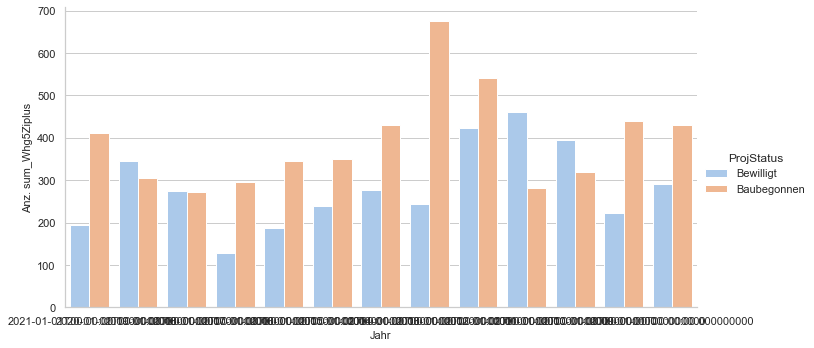

In [39]:
#sns.color_palette("flare", as_cmap=True)
myHist = sns.catplot(x="Jahr"
            , y="sum_Whg5Ziplus"
            , hue="ProjStatus"
            , kind="bar" #boxen, violin, --> wenn die aggregation nicht genau den werten in der grafik entspricht
            , palette="pastel" #, color="green"
            , height=5
            , aspect=2
            , order=None, legend_out=True
            ,data=myAggBar.reset_index()
           )
myHist.set_xlabels('Jahr', fontsize=11) # not set_label
myHist.set_ylabels('Anz. sum_Whg5Ziplus', fontsize=11)


In [43]:
#data2betested.dtypes
data2betested.columns

Index(['QuarSort', 'QuarCd', 'QuarLang', 'KreisSort', 'KreisCd', 'KreisLang', 'ProjStatus',
       'ProjStatusSort', 'Whg1Zi', 'Whg2Zi', 'Whg3Zi', 'Whg4Zi', 'Whg5Ziplus', 'Jahr_str'],
      dtype='object')

##### ------------------ STOP Plausi 2022

##### Anzahl abgebrochene und fertig erstellte Wohnungen der letzten 2 Jahre pro Kreis nach StatZone und Eigentumsart

In [44]:
myAggBar = data2betested.loc["2019":"2021"]\
    .groupby(['KreisLang','QuarLang','ProjStatus']) \
    .agg(sum_Whg_abgebrochen=('Whg_abgebrochen', 'sum'),sum_Whg_fertigerstellt=('Whg_fertigerstellt', 'sum')) \
    .sort_values('sum_Whg_abgebrochen', ascending=True) 

KeyError: 'QuarLangEigentumsart'

In [42]:
g = sns.FacetGrid(myAggBar.reset_index(), col="KreisLang", hue="Eigentumsart", col_wrap=4, height=3,)
g.map(sns.scatterplot, "sum_Whg_abgebrochen", "sum_Whg_fertigerstellt", alpha=.8)
#g.map(sns.lineplot, "sum_Whg_abgebrochen","sum_Whg_fertigerstellt",alpha=.8)

g.add_legend()

KeyError: 'Eigentumsart'

### Daten in interaktiver Treemap zeigen
Dazu gibt es eine sehr nützliche Webseite https://plotly.com/python/treemaps/
Zu Farbskalen, siehe: https://plotly.com/python/builtin-colorscales/

#### Fertig erstellte Wohnungen nach Eigentumsart, Quartier und StatZone 2021

In [71]:
#data2betested.dtypes

In [72]:
myTreemapAgg = data2betested.loc["2021"]  \
    .groupby(['StatZone', 'QuarLang', 'Eigentumsart']) \
    .agg(sum_Whg_abgebrochen=('Whg_abgebrochen', 'sum'),sum_Whg_fertigerstellt=('Whg_fertigerstellt', 'sum')) \
    .sort_values('Eigentumsart', ascending=False) 

myTreemapAgg.reset_index().head(3)

,StatZone,QuarLang,Eigentumsart,sum_Whg_abgebrochen,sum_Whg_fertigerstellt
0,Zähringerstrasse,Rathaus,Übrige private Gesellschaften,0,0
1,ETH Hönggerberg,Höngg,Übrige private Gesellschaften,0,0
2,Neu-Oerlikon,Oerlikon,Übrige private Gesellschaften,3,0


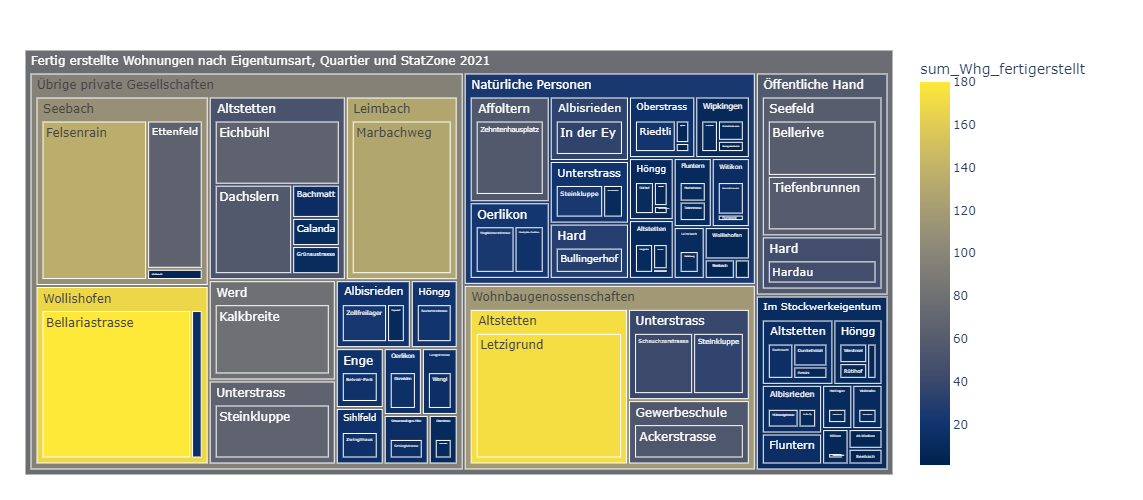

In [73]:
fig = px.treemap(myTreemapAgg.query('sum_Whg_fertigerstellt >0').reset_index(), path=[px.Constant("Fertig erstellte Wohnungen nach Eigentumsart, Quartier und StatZone 2021")
                                                                                      , 'Eigentumsart','QuarLang','StatZone']
                 , values='sum_Whg_fertigerstellt'
                 , color='sum_Whg_fertigerstellt'
                 ## bei discrete scales (bei Klassen und Strings):                 
                 #, color_discrete_map={'(?)':'lightgrey','EVP':'gold', 'SP':'#FF3030', 'PdA':'#EE3B3B', 'Grüne':'#A2CD5A','GLP':'#CAFF70','Die Mitte':'orange','FDP':'#104E8B','AL':'deeppink','SVP':'forestgreen', 'FL ZÜRI':'#8B864E','Volt':'#lightblue' }                
                 ## bei continuous scales (bei Zahlenwerten):
                , color_continuous_scale='cividis'
                #, color_continuous_midpoint=np.average(df['AnzBestWir'], weights=df['AnzBestWir'])  
                 ,height=500
                 ,width=1100                 
                )
fig.update_traces(root_color="grey")
fig.update_layout(margin = dict(t=50, l=25, r=250, b=25))
fig.show()

#### Fertig erstellte Wohnungen nach Jahr und Quartier seit 2009

In [108]:
#data2betested.dtypes

In [109]:
myTreemapAgg = data2betested.loc["2009":"2021"].reset_index()  \
    .groupby(['Jahr', 'QuarLang']) \
    .agg(sum_Whg_abgebrochen=('Whg_abgebrochen', 'sum'),sum_Whg_fertigerstellt=('Whg_fertigerstellt', 'sum')) \
    .sort_values('QuarLang', ascending=False) 

myTreemapAgg.reset_index().head(3)

,Jahr,QuarLang,sum_Whg_abgebrochen,sum_Whg_fertigerstellt
0,2021-01-01,Wollishofen,4,214
1,2014-01-01,Wollishofen,91,75
2,2012-01-01,Wollishofen,30,38


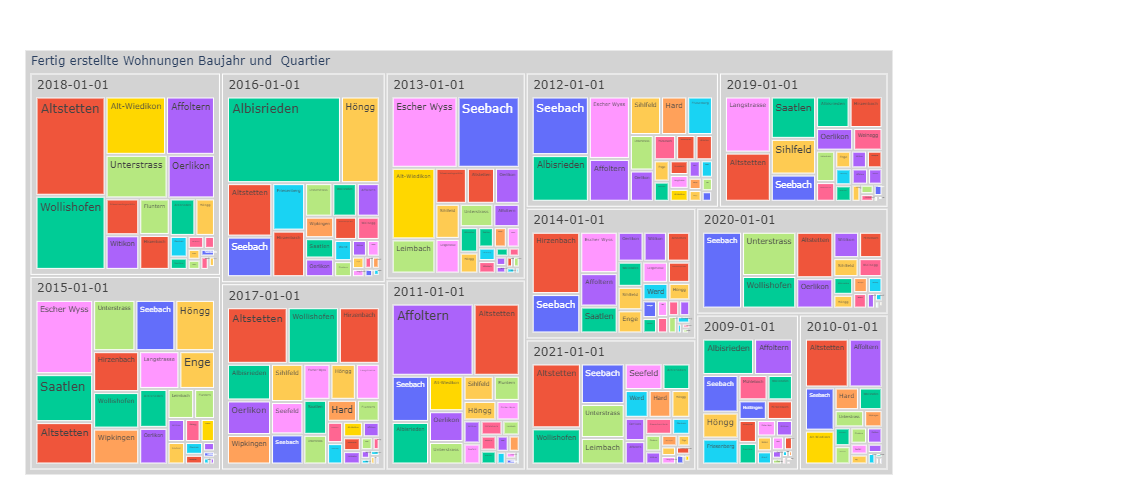

In [112]:
fig = px.treemap(myTreemapAgg.query('sum_Whg_fertigerstellt >0').reset_index(), path=[px.Constant("Fertig erstellte Wohnungen Baujahr und  Quartier")
                                                                                      , 'Jahr','QuarLang']
                 , values='sum_Whg_fertigerstellt'
                 , color='QuarLang'
                 ## bei discrete scales (bei Klassen und Strings):                 
                 , color_discrete_map={'(?)':'lightgrey','Alt-Wiedikon':'gold', 'SP':'#FF3030', 'PdA':'#EE3B3B', 'Grüne':'#A2CD5A','GLP':'#CAFF70','Die Mitte':'orange','FDP':'#104E8B','AL':'deeppink','SVP':'forestgreen', 'FL ZÜRI':'#8B864E','Volt':'#lightblue' }                
                 ## bei continuous scales (bei Zahlenwerten):
                #, color_continuous_scale='cividis'
                #, color_continuous_midpoint=np.average(df['AnzBestWir'], weights=df['AnzBestWir'])  
                 ,height=500
                 ,width=1100                 
                )
fig.update_traces(root_color="grey")
fig.update_layout(margin = dict(t=50, l=25, r=250, b=25))
fig.show()

In [117]:
#data2betested.dtypes

## ---------------------- hier Plausi beendet

Liniendiagramm 
[Link zur Doku](https://altair-viz.github.io/gallery/multiline_highlight.html)

### Test: Choroplethenkarte
Importiere die Geodaten als GeoJSON

#### Stadtkreise

In [124]:
# Read abt. Geopandas https://geopandas.org/docs/user_guide/io.html
geojson_url_kreise = "https://www.ogd.stadt-zuerich.ch/wfs/geoportal/Stadtkreise?service=WFS&version=1.1.0&request=GetFeature&outputFormat=GeoJSON&typename=adm_stadtkreise_v"
adm_stadtkreise_v = gpd.read_file(geojson_url_kreise)

adm_stadtkreise_v.head(1)


,id,kname,knr,objid,geometry
0,adm_stadtkreise_v.6,Kreis 7,7,6,"POLYGON ((8.54885 47.36602, 8.54901 47.36601, ..."


#### Statistische Zonen

In [115]:
# Read abt. Geopandas https://geopandas.org/docs/user_guide/io.html
geojson_url_statzonen = "https://www.ogd.stadt-zuerich.ch/wfs/geoportal/Statistische_Zonen?service=WFS&version=1.1.0&request=GetFeature&outputFormat=GeoJSON&typename=adm_statzonen_map"
adm_statzonen_map = gpd.read_file(geojson_url_statzonen)

adm_statzonen_map.head(2)


,id,kname,knr,objectid,objid,qname,qnr,stzname,stznr,geometry
0,adm_statzonen_map.1,Kreis 7,7,1,154,Hirslanden,73,Hegibach,7303,"POLYGON ((8.55670 47.36406, 8.55682 47.36410, ..."
1,adm_statzonen_map.2,Kreis 7,7,2,89,Hirslanden,73,Klus,7302,"POLYGON ((8.57281 47.35806, 8.57278 47.35807, ..."


#### Statistische Quartiere

In [119]:
geojson_url_quartiere = "https://www.ogd.stadt-zuerich.ch/wfs/geoportal/Statistische_Quartiere?service=WFS&version=1.1.0&request=GetFeature&outputFormat=GeoJSON&typename=adm_statistische_quartiere_map"
df_adm_statistische_quartiere_map = gpd.read_file(geojson_url_quartiere)

df_adm_statistische_quartiere_map.head(2)


,id,kname,knr,objectid,objid,qname,qnr,geometry
0,adm_statistische_quartiere_map.1,Kreis 7,7,1,34,Hirslanden,73,"POLYGON ((8.55670 47.36406, 8.55682 47.36410, ..."
1,adm_statistische_quartiere_map.2,Kreis 8,8,2,33,Weinegg,83,"POLYGON ((8.55670 47.36405, 8.55672 47.36403, ..."


### Joins
Joine die importierten statistischen Daten des aktuellen Jahres zum Geodatensatz:

*Siehe dazu Doku zu [Geopandas](https://geopandas.org/docs/user_guide/mergingdata.html)*

In [127]:
data2betested.dtypes

StatZoneCd             int64
StatZone              object
QuarCd                 int64
QuarLang              object
KreisCd                int64
KreisLang             object
EigentumsartSort       int64
Eigentumsart          object
Whg_abgebrochen        int64
Whg_fertigerstellt     int64
dtype: object

In [137]:
myAgg = data2betested.loc["2021"]  \
    .groupby(['QuarLang', 'QuarCd']) \
    .agg(sum_Whg_abgebrochen=('Whg_abgebrochen', 'sum'),sum_Whg_fertigerstellt=('Whg_fertigerstellt', 'sum')) \
    .sort_values('sum_Whg_abgebrochen', ascending=False) 

myAgg.reset_index().head(1)


,QuarLang,QuarCd,sum_Whg_abgebrochen,sum_Whg_fertigerstellt
0,Albisrieden,91,282,89


In [138]:
# Rename attribute stznr to StatZoneSort, so the IDs have the same name
gdf_adm_statistische_quartiere_map = df_adm_statistische_quartiere_map[['geometry', 'qnr', 'qname', 'knr']].rename(columns={'qnr': 'QuarCd'})
gdf_adm_statistische_quartiere_map.head(1)

,geometry,QuarCd,qname,knr
0,"POLYGON ((8.55670 47.36406, 8.55682 47.36410, ...",73,Hirslanden,7


In [139]:
# Merge with `merge` method on shared variable (stznr und StatZoneSort):
gdf_adm_statistische_quartiere_map_joined = gdf_adm_statistische_quartiere_map.merge(myAgg, on='QuarCd')
gdf_adm_statistische_quartiere_map_joined.head(2)


,geometry,QuarCd,qname,knr,sum_Whg_abgebrochen,sum_Whg_fertigerstellt
0,"POLYGON ((8.55670 47.36406, 8.55682 47.36410, ...",73,Hirslanden,7,48,2
1,"POLYGON ((8.55670 47.36405, 8.55672 47.36403, ...",83,Weinegg,8,2,0


<AxesSubplot:>

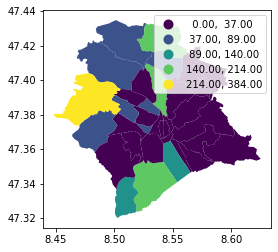

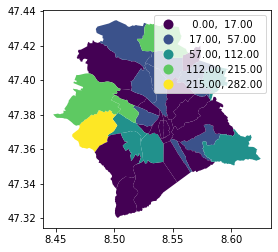

In [142]:
# Plot by StatQuartiere
# Weitere Schemes: scheme='quantiles', scheme='fisherjenks', scheme='natural_breaks',

gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_fertigerstellt', cmap='viridis', scheme='natural_breaks', legend=True )
gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_abgebrochen', cmap='viridis', scheme='natural_breaks', legend=True )

#gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_abgebrochen', cmap='plasma', scheme='fisherjenks', legend=True )
#gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_fertigerstellt', cmap='cool', scheme='quantiles', legend=True )
#scheme werte: https://matplotlib.org/2.0.2/users/colormaps.html

#
#Neuere Gallerie: https://matplotlib.org/stable/gallery/index.html

<AxesSubplot:>

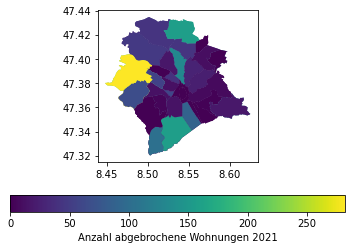

In [157]:
fig, ax = plt.subplots(1, 1)

gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_abgebrochen', ax=ax, legend=True, legend_kwds={'label': "Anzahl abgebrochene Wohnungen 2021",'orientation': "horizontal"})
gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_fertigerstellt', ax=ax, legend=False, legend_kwds={'label': "Anzahl fertigerstellte Wohnungen 2021",'orientation': "horizontal"})

#gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_abgebrochen', cmap='viridis', scheme='natural_breaks', legend=True , ax=ax, legend_kwds={'label': "Anzahl Personen",'orientation': "horizontal"})

Noch zu prüfen, folgendes schöne Beispiel: https://docs.bokeh.org/en/latest/docs/user_guide/interaction/legends.html

Konkrete Beispiele von Bookeh in Jupyter NB: https://docs.bokeh.org/en/latest/docs/user_guide/jupyter.html

**Sharepoint als gecheckt markieren!**

Record auf Sharepoint: **[Link](http://kollaboration.intranet.stzh.ch/orga/ssz-produkte/Lists/SASA_Outputs/EditForm.aspx?ID=172&Source=%2Forga%2Fssz%2Dprodukte%2FLists%2FSASA%5FOutputs)**